In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeNormal,GlorotNormal
from tensorflow.keras.optimizers import Adam,RMSprop,Adagrad,SGD
from tensorflow.keras.regularizers import L1L2,l1,l2,L1,L2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

###  Data Collection & Preprocessing

- using yahoo finance API

In [3]:
ticker = "OGDC.KA"
start_date = "2021-01-01"
end_date = "2025-06-22"
data = yf.download(ticker, start=start_date, end=end_date)

# Select required columns and handle missing values
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.fillna(method='ffill', inplace=True)


data['Volume'] = data['Volume'].astype(int)

data.columns = data.columns.droplevel(1)  # Remove the ticker level from columns

data.to_csv('psx.csv', float_format='%.5f')

[*********************100%***********************]  1 of 1 completed


In [1]:
data= pd.read_csv("psx.csv", parse_dates=["Date"], index_col="Date")
data

NameError: name 'pd' is not defined

In [3]:
data.shape

(1150, 5)

In [4]:
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [5]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [6]:
data.isna().sum().sum()

np.int64(0)

### candlesticks

<Figure size 1200x600 with 0 Axes>

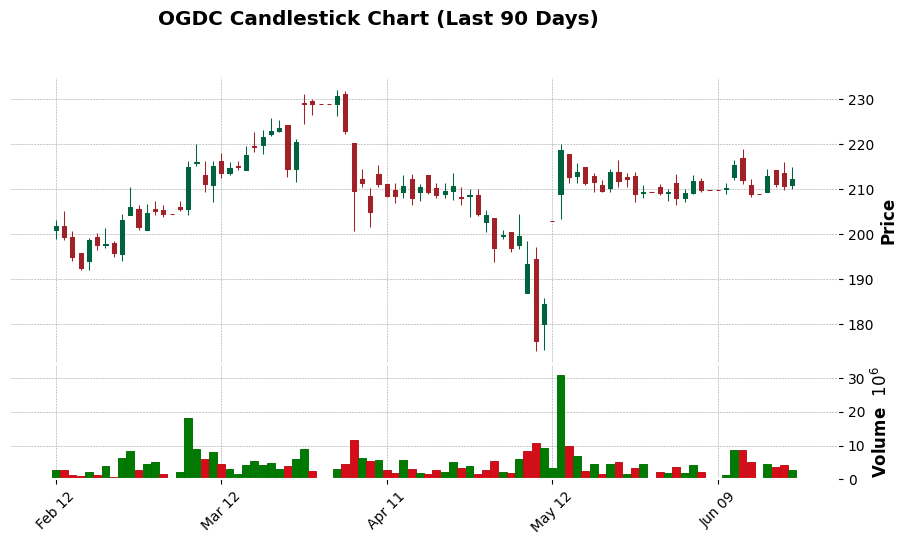

In [7]:
plt.figure(figsize=(12, 6))
mpf.plot(data[-90:],  # Last 90 days
         type='candle',
         style='charles',
         title='OGDC Candlestick Chart (Last 90 Days)',
         volume=True,
         figratio=(12, 6))
plt.close()

###  Data Preparation for LSTM

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
scaled_data.size

5750

In [10]:
# Sequence creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, 3])  # Close price is at index 3
    return np.array(X), np.array(y)


SEQ_LENGTH = 30
FEATURES = data.shape[1] 

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [129]:
FEATURES

5

In [130]:

# LSTM expects input of shape:
# (batchsize,sequencelength,numfeatures)(batchs​ize,sequencel​ength,numf​eatures)

In [93]:
X.shape

(1130, 20, 5)

In [94]:
y.shape

(1130,)

In [131]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.1)

In [11]:
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nData prepared for LSTM:")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Data prepared for LSTM:
Training set: (1008, 30, 5), (1008,)
Testing set: (112, 30, 5), (112,)


In [12]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (1008, 30, 5), (1008,)
Testing set: (112, 30, 5), (112,)


In [13]:
X_train.shape

(1008, 30, 5)

In [14]:
X_test.shape

(112, 30, 5)

###  LSTM Model Architecture


In [36]:
model = Sequential([
    # First LSTM layer with 64 units, returns sequences for the next LSTM layer
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2]), kernel_regularizer=L1(0.001)),
    Dropout(0.3),  # Increased dropout rate to 0.3 for better regularization
    # Second LSTM layer with 32 units, no sequences returned
    LSTM(32, return_sequences=False),
    # Dropout(0.3),  # Increased dropout rate to 0.3
    Dense(1)  # Output layer for regression (e.g., predicting Close price)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# checkpoint = ModelCheckpoint('weights/lstm_model.keras', 
#                             monitor='val_loss', 
#                             save_best_only=True, 
#                             verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1)
# Save the final model
model.save('weights/final_lstm_model.keras')

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0870 - val_loss: 0.0448
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0335 - val_loss: 0.0181
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0101 - val_loss: 0.0112
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0055 - val_loss: 0.0133
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - val_loss: 0.0192
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0108
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0146
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

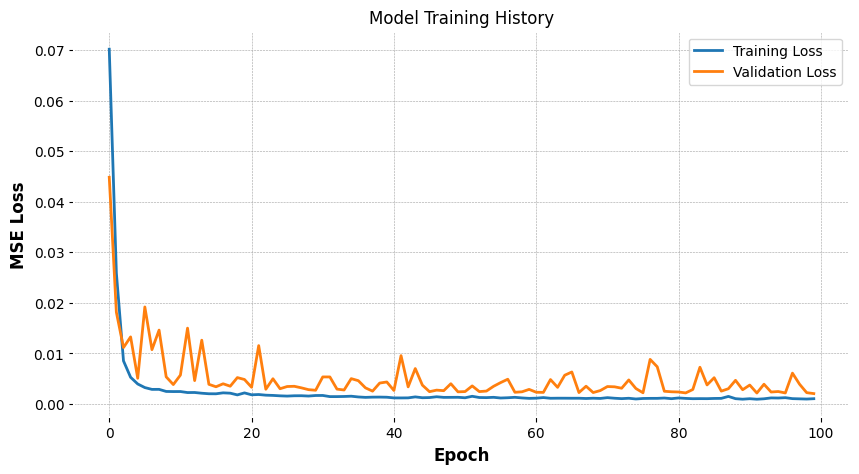

In [38]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()

In [39]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [40]:
model = load_model('weights/final_lstm_model.keras')  # Load best model
y_pred = model.predict(X_test)

# Create dummy array for inverse transform
dummy_array = np.zeros((len(y_pred), FEATURES))
dummy_array[:, 3] = y_pred.flatten()  # Close price position
test_predictions = scaler.inverse_transform(dummy_array)[:, 3]

# Actual prices
actual_prices = data['Close'].values[-len(y_test):]

# Error metrics
mae = np.mean(np.abs(test_predictions - actual_prices))
rmse = np.sqrt(np.mean((test_predictions - actual_prices)**2))
mape = np.mean(np.abs((actual_prices - test_predictions) / actual_prices)) * 100

print("\nModel Evaluation:")
print(f"MAE: {mae:.2f} PKR")
print(f"RMSE: {rmse:.2f} PKR")
print(f"MAPE: {mape:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Model Evaluation:
MAE: 5.39 PKR
RMSE: 7.06 PKR
MAPE: 2.62%


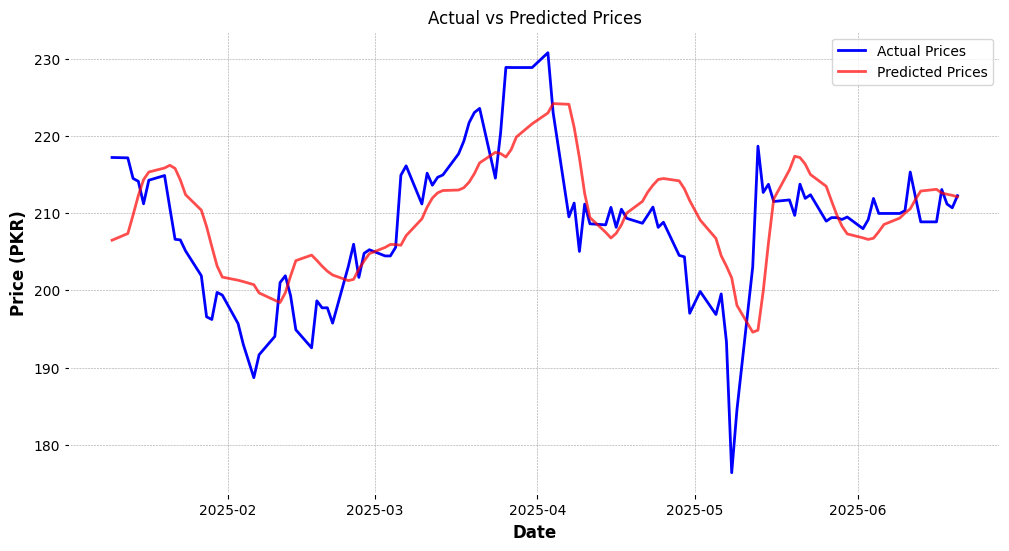

In [41]:
# Prediction visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
plt.plot(data.index[-len(test_predictions):], test_predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price (PKR)')
plt.legend()
plt.show()

### Future Price Prediction

In [43]:
def predict_future(model, last_sequence, future_days):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_days):
        # Predict next day
        pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, FEATURES))[0, 0]
        
        # Create new row (using predicted close for all OHLC - simplified approach)
        new_row = current_sequence[-1].copy()
        new_row[3] = pred  # Close price
        new_row[0] = current_sequence[-1][3]  # Open = previous close
        new_row[1] = max(current_sequence[-1][1], pred)  # High
        new_row[2] = min(current_sequence[-1][2], pred)  # Low
        # Volume remains the same
        
        # Update sequence
        current_sequence = np.vstack([current_sequence[1:], new_row])
        predictions.append(pred)
    
    return predictions

# Get last sequence
last_sequence = scaled_data[-SEQ_LENGTH:]

# Calculate days to target dates
target_dates = ["2025-09-01", "2025-12-01", "2026-06-01"]
current_date = data.index[-1].date()
future_days = {
    "2025-09-01": (datetime.strptime("2025-09-01", "%Y-%m-%d").date() - current_date).days,
    "2025-12-01": (datetime.strptime("2025-12-01", "%Y-%m-%d").date() - current_date).days,
    "2026-06-01": (datetime.strptime("2026-06-01", "%Y-%m-%d").date() - current_date).days
}

# Predict future prices
all_predictions = predict_future(model, last_sequence, max(future_days.values()))
predicted_prices = {}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [44]:
# Inverse transform predictions
for date, days in future_days.items():
    dummy = np.zeros((1, FEATURES))
    dummy[0, 3] = all_predictions[days-1]
    unscaled = scaler.inverse_transform(dummy)[0, 3]
    predicted_prices[date] = unscaled

print("\nPredicted Prices:")
for date, price in predicted_prices.items():
    print(f"{date}: {price:.2f} PKR")


Predicted Prices:
2025-09-01: 218.42 PKR
2025-12-01: 218.75 PKR
2026-06-01: 218.76 PKR


In [233]:
print("\nChecking investment date availability:")
print(f"Requested investment date: {investment_date}")
print(f"Available dates around investment date:")
print(data.loc['2025-05-25':'2025-06-05'])


Checking investment date availability:
Requested investment date: 2025-06-01
Available dates around investment date:
                 Open       High        Low      Close   Volume
Date                                                           
2025-05-26  213.00000  213.80000  207.14999  208.95000  3432433
2025-05-27  209.25000  210.89999  208.00000  209.41000  4443220
2025-05-28  209.41000  209.41000  209.41000  209.41000        0
2025-05-29  210.47000  211.14999  208.80000  209.17000  2255894
2025-05-30  209.10001  210.10001  207.50000  209.49001  1912843
2025-06-02  211.38000  213.50000  206.50000  207.98000  3666183
2025-06-03  208.00000  210.00000  207.25000  209.14999  1909426
2025-06-04  209.14999  213.13000  208.95000  211.89000  4379550
2025-06-05  211.89000  212.50000  209.50000  209.95000  2233027


### Investment Simulation
#### Get price on investment date (June 1, 2025)

In [45]:
investment_date = "2025-05-30"
investment_price = data.loc[investment_date]['Close']
investment_amount = 10000  # PKR

# Calculate shares purchased
shares = investment_amount / investment_price

# Calculate returns
results = {}
for date, price in predicted_prices.items():
    value = shares * price
    profit = value - investment_amount
    results[date] = {
        'price': price,
        'value': value,
        'profit': profit
    }

In [46]:
print(results)

{'2025-09-01': {'price': np.float64(218.41924420422257), 'value': np.float64(10426.236754880223), 'profit': np.float64(426.2367548802231)}, '2025-12-01': {'price': np.float64(218.7534494328624), 'value': np.float64(10442.190032491879), 'profit': np.float64(442.1900324918788)}, '2026-06-01': {'price': np.float64(218.757283925727), 'value': np.float64(10442.373071905768), 'profit': np.float64(442.3730719057676)}}


In [47]:
print(f"\nInvestment Simulation (10,000 PKR on {investment_date}):")
print(f"Purchase Price: {investment_price:.2f} PKR")
print(f"Shares Purchased: {shares:.4f}\n")
print("Projected Returns:")
for date, res in results.items():
    print(f"{date}:")
    print(f"  Predicted Price: {res['price']:.2f} PKR")
    print(f"  Portfolio Value: {res['value']:.2f} PKR")
    print(f"  Profit/Loss: {res['profit']:.2f} PKR")
    print()


Investment Simulation (10,000 PKR on 2025-05-30):
Purchase Price: 209.49 PKR
Shares Purchased: 47.7350

Projected Returns:
2025-09-01:
  Predicted Price: 218.42 PKR
  Portfolio Value: 10426.24 PKR
  Profit/Loss: 426.24 PKR

2025-12-01:
  Predicted Price: 218.75 PKR
  Portfolio Value: 10442.19 PKR
  Profit/Loss: 442.19 PKR

2026-06-01:
  Predicted Price: 218.76 PKR
  Portfolio Value: 10442.37 PKR
  Profit/Loss: 442.37 PKR

